In [77]:
import numpy as np 
import pandas as pd

index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's{i}' for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names


df_train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names, engine='python')
df_test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names, engine='python')
df_test_rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'], engine='python')

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\GIGABYT\AppData\Local\Temp\ipykernel_15612\471796726.py:10: SyntaxWarning: invalid escape sequence '\s'
  df_train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names, engine='python')
C:\Users\GIGABYT\AppData\Local\Temp\ipykernel_15612\471796726.py:11: SyntaxWarning: invalid escape sequence '\s'
  df_test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names, engine='python')
C:\Users\GIGABYT\AppData\Local\Temp\ipykernel_15612\471796726.py:12: SyntaxWarning: invalid escape sequence '\s'
  df_test_rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'], engine='python')


In [78]:
df_train.head()

,engine,cycle,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


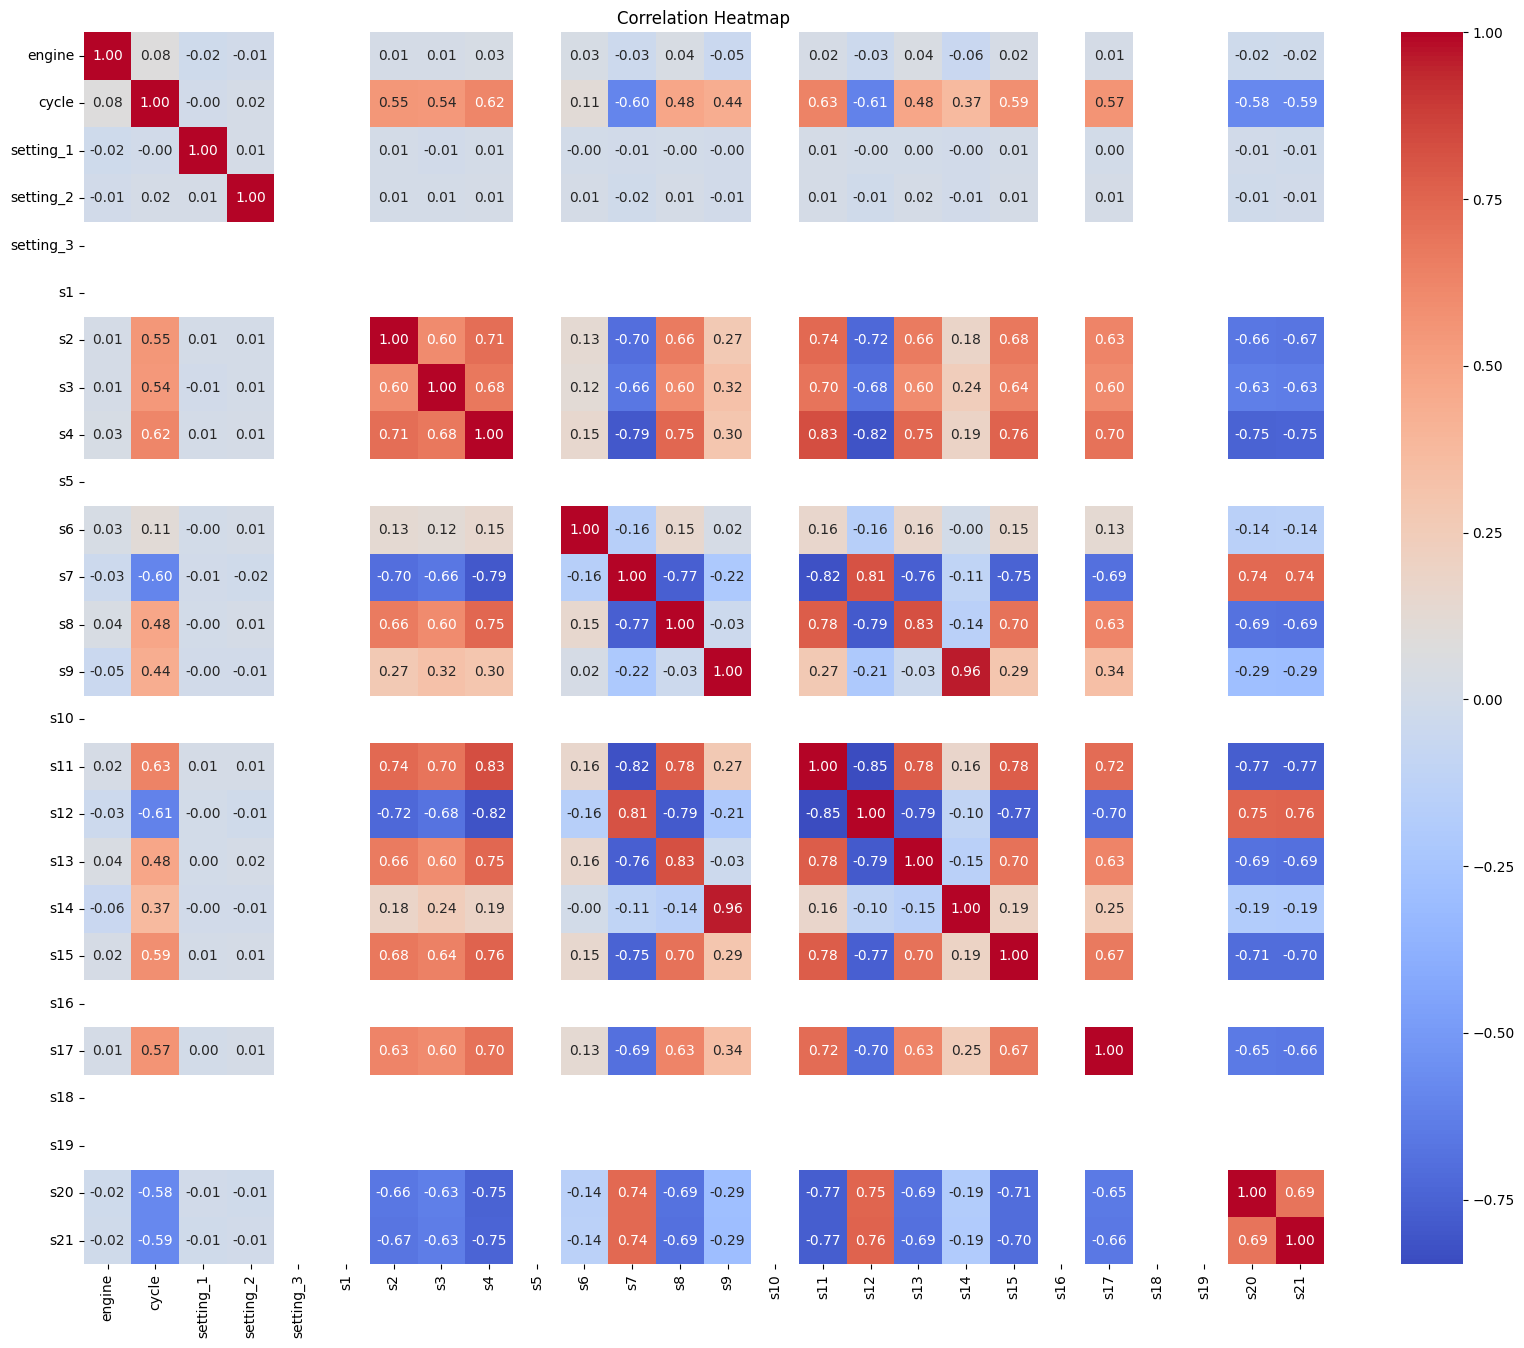

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 16))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f", cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title("Correlation Heatmap")
plt.show()


In [80]:
#dropping const values
sens_const_values = []
for feature in list(setting_names + sensor_names):
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)
df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)

['setting_3', 's1', 's5', 's10', 's16', 's18', 's19']


In [81]:
max_cycle = df_train.groupby('engine')['cycle'].max()
df_train = df_train.merge(max_cycle.rename('max_cycle'), on='engine')
df_train['RUL'] = df_train['max_cycle'] - df_train['cycle']
df_train.drop(columns=['max_cycle'], inplace=True)

In [82]:
last_cycle_test = df_test.groupby('engine')['cycle'].max().reset_index()
df_test_last = df_test.merge(last_cycle_test, on=['engine', 'cycle'])
df_test_last['RUL'] = df_test_rul['RUL']
df_test = df_test.merge(df_test_last[['engine', 'RUL']], on='engine', how='left')


In [83]:
features = [col for col in df_train.columns if col not in ['engine', 'cycle', 'RUL']]
def generate_sequences(df, window_size=30):
    sequences = []
    labels = []

    for engine_id, group in df.groupby('engine'):
        group = group.sort_values('cycle')
        data = group[features].values
        rul = group['RUL'].values

        for i in range(len(group) - window_size + 1):
            x = data[i:i+window_size]
            y = rul[i+window_size-1]  

            sequences.append(x)
            labels.append(y)

    return np.array(sequences), np.array(labels)


In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features] = scaler.transform(df_test[features])


In [85]:
window_size = 30
X_train, y_train = generate_sequences(df_train, window_size)


In [86]:
import torch
from torch.utils.data import Dataset, DataLoader

class CMAPSSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CMAPSSDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [87]:
def generate_test_sequences(df, df_rul, window_size=30):
    sequences = []
    labels = []

    for engine_id, group in df.groupby('engine'):
        group = group.sort_values('cycle')
        data = group[features].values

        if len(group) >= window_size:
            x = data[-window_size:]  
            y = df_rul.loc[engine_id - 1, 'RUL']  

            sequences.append(x)
            labels.append(y)

    return np.array(sequences), np.array(labels)


In [88]:
X_test, y_test = generate_test_sequences(df_test, df_test_rul, window_size)
test_dataset = CMAPSSDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [89]:
from torch import nn


import torch

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 17
        self.lstm1 = nn.LSTM(self.input_size, 64, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (lstm1): LSTM(17, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [90]:
import torch.optim.adam

loss_fn = nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters() ,lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [91]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).view(-1,1)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{(batch + 1) * len(X):>5d}/{size:>5d}]")
    
    return total_loss / len(dataloader)


In [92]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)  
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f}\n")
    return test_loss

In [93]:
epochs = 50
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer)
    test_loss = test(test_loader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    scheduler.step(test_loss)

print("Done!")


Epoch 1
-------------------------------
loss: 15619.013672  [   64/17731]
loss: 12638.097656  [ 6464/17731]
loss: 12849.083008  [12864/17731]
Test Error: Avg loss: 6410.091309

Epoch 2
-------------------------------
loss: 9968.286133  [   64/17731]
loss: 10200.136719  [ 6464/17731]
loss: 13551.242188  [12864/17731]
Test Error: Avg loss: 5791.687744

Epoch 3
-------------------------------
loss: 11400.339844  [   64/17731]
loss: 9085.037109  [ 6464/17731]
loss: 10420.134766  [12864/17731]
Test Error: Avg loss: 5351.919678

Epoch 4
-------------------------------
loss: 9174.591797  [   64/17731]
loss: 8431.945312  [ 6464/17731]
loss: 8779.860352  [12864/17731]
Test Error: Avg loss: 4969.375732

Epoch 5
-------------------------------
loss: 7952.472168  [   64/17731]
loss: 8919.181641  [ 6464/17731]
loss: 6736.335449  [12864/17731]
Test Error: Avg loss: 4620.425293

Epoch 6
-------------------------------
loss: 9865.427734  [   64/17731]
loss: 9193.234375  [ 6464/17731]
loss: 8408.030273

KeyboardInterrupt: 

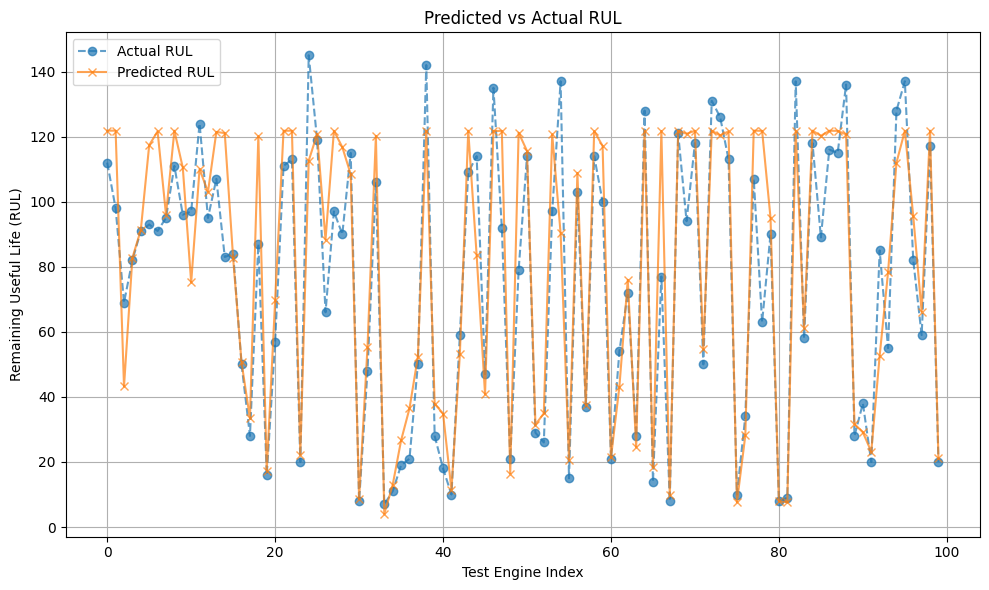

In [94]:
import matplotlib.pyplot as plt

# Collect predictions and actual RULs
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).view(-1, 1)
        
        preds = model(X_batch)
        predictions.extend(preds.cpu().numpy().flatten())
        actuals.extend(y_batch.cpu().numpy().flatten())

# Convert to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual RUL', marker='o', linestyle='--', alpha=0.7)
plt.plot(predictions, label='Predicted RUL', marker='x', linestyle='-', alpha=0.7)
plt.xlabel('Test Engine Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Predicted vs Actual RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
